# Disruption prediction model training demo

 this notebook shows how to build a ML mode to predict disruption and
 generating a result csv file for evaluation.

 Note, this is a toy model build with little J-TEXT data. You are expecting to train the model with lots of J-TEXT, HL-2A and a few C-mod data, then generating testing result csv file using the C-Mod evaluation data.
 
 this depends on the output FileRepo of basic_data_processing.py


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from jddb.performance import Result
from jddb.performance import Report
from jddb.file_repo import FileRepo



c:\Users\zhengwei\Anaconda3\envs\experiment\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\zhengwei\Anaconda3\envs\experiment\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\zhengwei\Anaconda3\envs\experiment\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\zhengwei\Anaconda3\envs\experiment\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\zhengwei\Anaconda3\envs\experiment\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary 


## build training data from file repo

The below defined functions are used to generate model specific samples. The algorithms used in the toy model is LightGBM.

`matrix_build` Note, this function built nparray objects that can be used directly for the LightGBM training from the processed Filerepo. This is very import for getting samples ready for the model training.

It extract each time step in the time series data, put every channel expect alarm_tag in x, the alarm_tag is the y.

`get_shot_result` get disruption prediction result on shot using the output of the model on one shot

In [3]:
# this function built nparray objects that can be used directly for the LightGBM training from the processed Filerepo
def matrix_build(shot_list, file_repo, tags):
    """
    get x and y from file_repo by shots and tags
    Args:
        shot_list: shots for data matrix
        file_repo:
        tags: tags from file_repo

    Returns: matrix of x and y

    """
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# get disruption prediction result on shot using the output of the model on one shot
def get_shot_result(y_pred, threshold_sample):
    """
    get shot result by a threshold and compare to start time
    Args:
        y_pred: sample result from model
        threshold_sample: disruptive predict level

    Returns:
        shot predict result:The prediction result for the shot

    """
    binary_result = 1 * (y_pred >= threshold_sample)
    for k in range(len(binary_result) - 2):
        if np.sum(binary_result[k:k + 3]) == 3:
            predicted_dis = 1
            break
        else:
            predicted_dis = 0
    return predicted_dis



## Load all the data from the precessed filerepo and to the test and train split

### Load the data

In [4]:
test_file_repo = FileRepo(
    ".//data//jtext_data_train//$shot_2$00//")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])
# disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])


53


## build model specific data

Below with create sample for the model training and inference.

### Train test split

train test split on shot not sample according to whether shots are disruption.

set test_size=0.5 to get 50% shots as test set

Then use the `matrix_build` to get training sample x and y from the shot time series data.

In [5]:
# train test split on shot not sample according to whether shots are disruption
# set test_size=0.5 to get 50% shots as test set
train_shots, test_shots, _, _ = \
    train_test_split(test_shot_list, is_disrupt, test_size=0.2,
                        random_state=1, shuffle=True, stratify=is_disrupt)

# # create x and y matrix for ML models
# # %%
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)
lgb_train = lgb.Dataset(X_train, y_train)  # create dataset for LightGBM
lgb_val = lgb.Dataset(X_test, y_test)  # create dataset for LightGBM


## Build the LightGBM model

In [6]:
# hyper-parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},

    'is_unbalance': True

}
evals_result = {}  # to record eval results for plotting
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets={lgb_train, lgb_val},
                evals_result=evals_result,
                early_stopping_rounds=30)


Starting training...
[LightGBM] [Info] Number of positive: 1322, number of negative: 8222
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8644
[LightGBM] [Info] Number of data points in the train set: 9544, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138516 -> initscore=-1.827668
[LightGBM] [Info] Start training from score -1.827668
[1]	training's auc: 0.979819	valid_0's auc: 0.724213
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.990634	valid_0's auc: 0.782385
[3]	training's auc: 0.991654	valid_0's auc: 0.791654
[4]	training's auc: 0.99298	valid_0's auc: 0.828375
[5]	training's auc: 0.993799	valid_0's auc: 0.847642
[6]	training's auc: 0.995554	valid_0's auc: 0.849433
[7]	training's auc: 0.997142	valid_0's auc: 0.850075
[8]	training's auc: 0.997228	valid_0's auc: 0.841008
[

c:\Users\zhengwei\Anaconda3\envs\experiment\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\zhengwei\Anaconda3\envs\experiment\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


## Save the results for evaluation

save sample result to a dict, so when predicting shot with different trigging logic. Trigger logic is whe you have positive prediction for a sample, it does not means raising an alarm for the shot. You may want to count for a few positives in a roll to trigger the alarm.

It you want to test different trigger logic, you don't have to re-infer the test shots

In [9]:
# generate predictions for each shot
shot_nos = test_shots  # shot list
shots_pred_disrurption = []  # shot predict result
shots_true_disruption = [ ]  # shot true disruption label
shots_pred_disruption_time = []  # shot predict time
for shot in test_shots:
    true_disruption = 0 if test_file_repo.read_labels(shot)["IsDisrupt"] == False else 1
    shots_true_disruption.append(true_disruption)

    X, _ = matrix_build([shot], test_file_repo, tag_list)
    # get sample result from LightGBM
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)

    # using the sample reulst to predict disruption on shot
    predicted_disruption = get_shot_result(y_pred, .5)  # get shot result by a threshold
    shots_pred_disrurption.append(predicted_disruption)

# add predictions for each shot to the result dataframe
pred_result = pd.DataFrame({'Shot': shot_nos,
                            'shot_pred': shots_pred_disrurption})
pred_result.to_csv(r'.\_temp_test\test_result.csv')

## Evaluate the result using confusion matrix

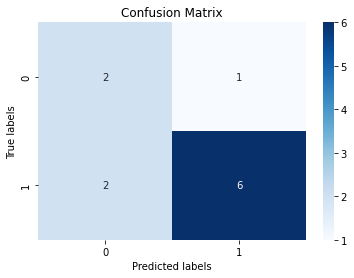

In [10]:
# %% plot some of the result: confusion matrix
matrix = confusion_matrix(shots_true_disruption, shots_pred_disrurption)
sns.heatmap(matrix, annot=True, cmap="Blues", fmt='.0f')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
# plt.savefig(os.path.join('..//_temp_test//', 'Confusion Matrix.png'), dpi=300)
plt.show()
